In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import các thư viện model boosting
from xgboost import XGBRegressor
import lightgbm as lgb

In [2]:
# =============================================================================
# 1. CONFIGURATION & DATA LOADING
# =============================================================================
FILE_PATH = "/kaggle/input/ds-prj/final_earthquake_data_2002_2025.csv"

# Load data
try:
    df = pd.read_csv(FILE_PATH)
    print("✅ Data loaded successfully!")
    print(f"Initial shape: {df.shape}")
except FileNotFoundError:
    print(f"❌ File not found at: {FILE_PATH}")

# Time processing for filtering
if 'year' not in df.columns:
    # Convert Timestamp to datetime if not already present
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df['year'] = df['Timestamp'].dt.year

# Filter data by year
max_year = df['year'].max()
cutoff_year = max_year  # Adjust this (e.g., 2010) if needed
print(f"--- Using data from year {cutoff_year} to {max_year} ---")

df = df[df['year'] >= cutoff_year].copy()

✅ Data loaded successfully!
Initial shape: (2921770, 28)
--- Using data from year 2025 to 2025 ---


In [3]:
df.columns

Index(['Timestamp', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'magType',
       'nst', 'gap', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'status', 'locationSource',
       'magSource', 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear',
       'energy', 'magnitude_category', 'depth_category'],
      dtype='object')

In [4]:
# =============================================================================
# 2. DATA CLEANING
# =============================================================================
# List of columns to drop (Leakage or irrelevant Metadata)
cols_to_drop = [
    'energy', 'magnitude_category', 'depth_category',
    'id', 'updated', 'place', 'status', 'Timestamp', 'year', 'month', 'day',
    'mag' # If 'Magnitude' is the target, 'mag' is usually a duplicate/leakage
]

# Drop columns only if they exist
existing_cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df_clean = df.drop(columns=existing_cols_to_drop, errors='ignore')

# Define features and target
potential_features = ['Latitude', 'Longitude', 'Depth', 'gap', 'nst']
target_col = 'Magnitude'

# Check availability
available_features = [f for f in potential_features if f in df_clean.columns]
if target_col not in df_clean.columns:
    raise ValueError(f"Target column '{target_col}' not found in data!")

# Create final model dataframe (Drop NaNs)
df_model = df_clean[available_features + [target_col]].dropna()
print(f"Rows after cleaning (NaN removed): {len(df_model)}")

X = df_model[available_features]
y = df_model[target_col]

Rows after cleaning (NaN removed): 121952



--- Starting Feature Selection ---


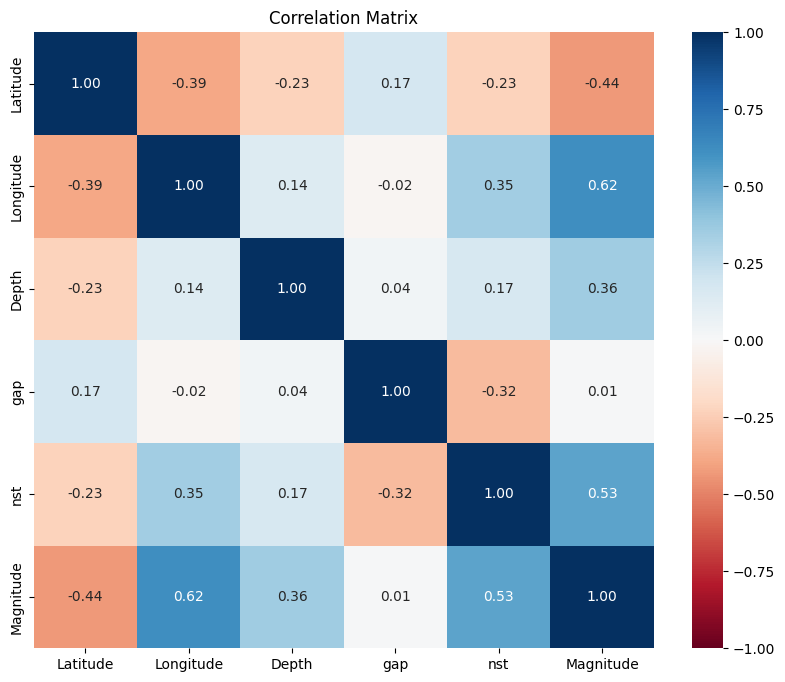

✅ RFE Selected Features: ['Latitude', 'Longitude', 'Depth', 'gap', 'nst']
📊 Feature Ranking (1 = Best): {'Latitude': 1, 'Longitude': 1, 'Depth': 1, 'gap': 1, 'nst': 1}


In [5]:
# =============================================================================
# 3. FEATURE SELECTION
# =============================================================================
print("\n--- Starting Feature Selection ---")

# A. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_model.corr(), annot=True, cmap='RdBu', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# B. RFE (Recursive Feature Elimination)
rf_selector = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
selector = RFE(estimator=rf_selector, n_features_to_select= 5, step=1)
selector.fit(X, y)

selected_vars = X.columns[selector.support_]
ranking = dict(zip(X.columns, selector.ranking_))

print(f"✅ RFE Selected Features: {list(selected_vars)}")
print(f"📊 Feature Ranking (1 = Best): {ranking}")

In [6]:
# =============================================================================
# 4. TRAIN / TEST SPLIT
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# Import thêm các thư viện cần thiết
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# =============================================================================
# 5. MODEL TRAINING & COMPARISON (CẬP NHẬT)
# =============================================================================
print("\n--- Training Models ---")

models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=300, max_depth=None, min_samples_leaf=5,
        random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=8,
        subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror',
        random_state=42, n_jobs=-1
    ),
    "LightGBM": lgb.LGBMRegressor(
        n_estimators=800, learning_rate=0.05, num_leaves=64,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1,
        verbose=-1
    ),

    "MLP_NeuralNet": make_pipeline(
        StandardScaler(),
        MLPRegressor(
            hidden_layer_sizes=200, 
            activation='tanh', 
            random_state=0, 
            solver='sgd',
            max_iter=500  
        )
    ),

    "SVR": make_pipeline(
        StandardScaler(),
        SVR(C=1.0, epsilon=0.2)
    )
}


--- Training Models ---


In [8]:
from sklearn.metrics import median_absolute_error, max_error, mean_absolute_percentage_error # Thêm các import còn thiếu

# Advanced Evaluation Function
def evaluate_model_advanced(model, name, X_test, y_test):
    preds = model.predict(X_test)

    # Basic Metrics
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    # Advanced Metrics
    medae = median_absolute_error(y_test, preds)       # Median Absolute Error (Robust to outliers)
    max_err = max_error(y_test, preds)                 # Max Error (Worst case)
    mape = mean_absolute_percentage_error(y_test, preds) * 100 # Percentage Error

    return {
        "Model": name,
        "RMSE": rmse,      # Lower is better
        "MAE": mae,        # Lower is better
        "MedAE": medae,    # Lower is better
        "Max Error": max_err, # Lower is better
        "MAPE (%)": mape,  # Lower is better
        "R2": r2           # Higher is better
    }

In [9]:
from sklearn.metrics import median_absolute_error, max_error, mean_absolute_percentage_error # Thêm các import còn thiếu

# Calculate Results
results_list_adv = []
for name, model in models.items():
    print(f"-> Training {name}...")
    model.fit(X_train, y_train)
    res = evaluate_model_advanced(model, name, X_test, y_test)
    results_list_adv.append(res)

# Create DataFrame
results_df = pd.DataFrame(results_list_adv).sort_values("RMSE")

print("\n🏆 DETAILED MODEL PERFORMANCE RANKING:")
print(results_df.round(4))

-> Training RandomForest...
-> Training XGBoost...
-> Training LightGBM...
-> Training MLP_NeuralNet...
-> Training SVR...

🏆 DETAILED MODEL PERFORMANCE RANKING:
           Model    RMSE     MAE   MedAE  Max Error      MAPE (%)      R2
0   RandomForest  0.3448  0.2468  0.1855     3.6917  2.021072e+14  0.9400
1        XGBoost  0.3471  0.2509  0.1904     3.6731  2.083780e+14  0.9392
2       LightGBM  0.3480  0.2516  0.1914     3.7148  2.106127e+14  0.9389
4            SVR  0.5234  0.3731  0.2710     3.7686  4.912486e+14  0.8618
3  MLP_NeuralNet  0.5309  0.3877  0.2899     4.0595  4.919874e+14  0.8578


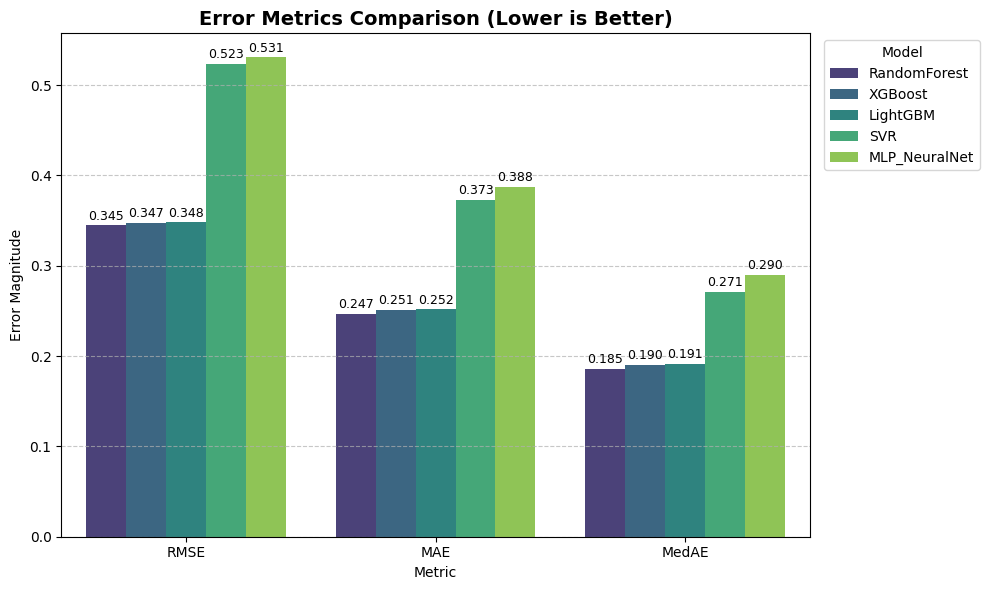

In [10]:
# =============================================================================
# VISUALIZATION 1: ERROR METRICS (RMSE, MAE, MedAE)
# =============================================================================
metrics_to_plot = ["RMSE", "MAE", "MedAE"]
df_plot_errors = results_df.melt(id_vars="Model", value_vars=metrics_to_plot, var_name="Metric", value_name="Error Value")

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Metric", y="Error Value", hue="Model", data=df_plot_errors, palette="viridis")

plt.title("Error Metrics Comparison (Lower is Better)", fontsize=14, fontweight='bold')
plt.ylabel("Error Magnitude")
plt.xlabel("Metric")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title="Model")

# Annotate bars
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    fontsize=9, color='black', xytext=(0, 2),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

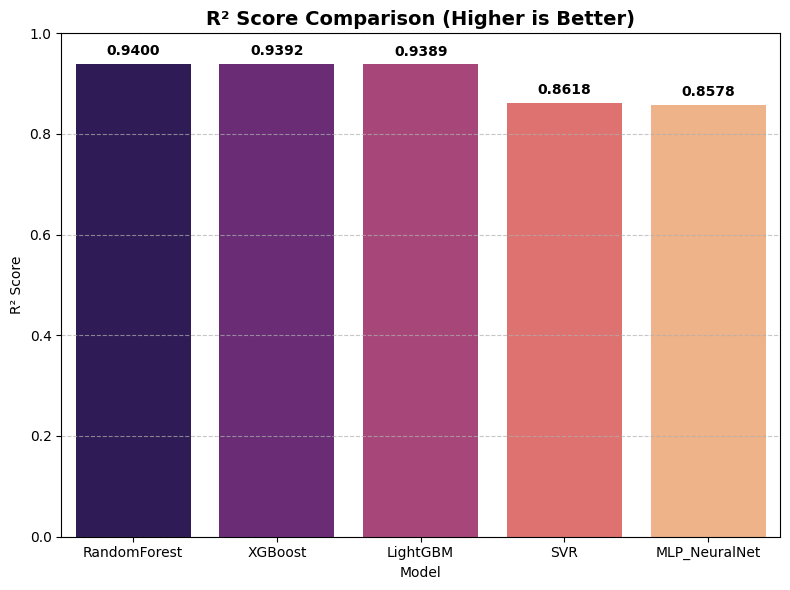

In [11]:
# =============================================================================
# VISUALIZATION 2: R-SQUARED SCORE (Accuracy)
# =============================================================================
plt.figure(figsize=(8, 6))
ax = sns.barplot(x="Model", y="R2", data=results_df, palette="magma")

plt.title("R² Score Comparison (Higher is Better)", fontsize=14, fontweight='bold')
plt.ylim(0, 1) # R2 typically ranges from 0 to 1
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontweight='bold', color='black')

plt.tight_layout()
plt.show()